![logo](../../picture/license_header_logo.png)
> **Copyright (c) 2020-2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program is part of OSRFramework. You can redistribute it and/or modify
<br>it under the terms of the GNU Affero General Public License as published by
<br>the Free Software Foundation, either version 3 of the License, or
<br>(at your option) any later version.
<br>
<br>This program is distributed in the hope that it will be useful,
<br>but WITHOUT ANY WARRANTY; without even the implied warranty of
<br>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
<br>GNU Affero General Public License for more details.
<br>
<br>You should have received a copy of the GNU Affero General Public License
<br>along with this program.  If not, see <http://www.gnu.org/licenses/>.
<br>

TODO

add description

In [1]:
import logging
import matplotlib.pyplot
import seaborn as sns

from datetime import *
from math import *
from numpy import *
from matplotlib import *
from pandas import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.base import clone
from sklearn.linear_model import *
from sklearn.neighbors import *
from sklearn.tree import *
from sklearn.svm import *
from sklearn.ensemble import *

In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('data/BeijingPollution/raw.txt',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('data/BeijingPollution/pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


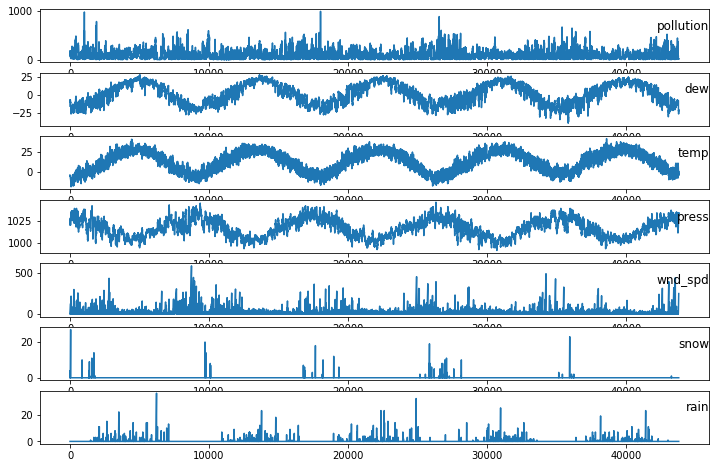

In [3]:
# load dataset
dataset = read_csv('data/BeijingPollution/pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(12,8))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
    
pyplot.show()

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('data/BeijingPollution/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      129.0      -16.0       -4.0     1020.0        2.0       1.79   
2      148.0      -15.0       -4.0     1020.0        2.0       2.68   
3      159.0      -11.0       -5.0     1021.0        2.0       3.57   
4      181.0       -7.0       -5.0     1022.0        2.0       5.36   
5      138.0       -7.0       -5.0     1022.0        2.0       6.25   

   var7(t-1)  var8(t-1)  var1(t)  
1        0.0        0.0    148.0  
2        0.0        0.0    159.0  
3        0.0        0.0    181.0  
4        1.0        0.0    138.0  
5        2.0        0.0    109.0  


In [5]:
values.shape

(43800, 8)

In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 8) (35040,) (8759, 8) (8759,)


In [7]:
# prepare a list of ml models
def get_linear_models(models=dict()):
    # linear models
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    models['huber'] = HuberRegressor()
    models['llars'] = LassoLars()
    models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
    models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
    print('----------------- Defined %d models' % len(models))
    return models

# prepare a list of ml models
def get_nonlinear_models(models=dict()):
    # non-linear models
    models['knn'] = KNeighborsRegressor(n_neighbors=7)
    models['cart'] = DecisionTreeRegressor()
    models['extra'] = ExtraTreeRegressor()
    models['svmr'] = SVR()
    print('----------------- Defined %d models' % len(models))
    return models

# prepare a list of ml models
def get_ensemble_models(models=dict()):
    n_trees = 100
    models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
    models['bag'] = BaggingRegressor(n_estimators=n_trees)
    models['rf'] = RandomForestRegressor(n_estimators=n_trees)
    models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
    models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
    print('----------------- Defined %d models' % len(models))
    return models

In [8]:
# fit one model for each variable and each forecast
def fit_model(model, train_X, train_y):
    # clone the model configuration
    local_model = clone(model)
    # fit the model
    return local_model.fit(train_X, train_y)

# return forecasts as [chunks][var][time]
def make_predictions(model, test_X):
    return array(model.predict(test_X))

def calculate_error(actual, predicted):
    # give the full actual value if predicted is nan
    if isnan(predicted):
        return abs(actual)
    # calculate abs difference
    return abs(actual - predicted)

def evaluate_forecasts(predictions, testset):
    total_mae = 0.0
    total_c = 0
    # convert to forecasts
    actual = testset
    predicted = predictions
    # enumerate target variables
    for j in range(predicted.shape[0]):
        # skip if actual in nan
        if isnan(actual[j]):
            continue
        # calculate error
        error = calculate_error(actual[j], predicted[j])
        # update statistics
        total_mae += error
        total_c += 1
    # normalize summed absolute errors
    total_mae /= total_c
    return total_mae

# summarize scores
def summarize_error(name, total_mae):
    print('%s: %.3f MAE' % (name, total_mae))
    
# evaluate a suite of models
def evaluate_models(models, train_X, train_y, test_X, test_y):
    pdict = dict()
    for name, model in models.items():
        # fit models
        fits = fit_model(model, train_X, train_y)
        # make predictions
        predictions = make_predictions(fits, test_X)
        # evaluate forecast
        mae = evaluate_forecasts(predictions, test_y)
        # summarize forecast
        summarize_error(name, mae)
        # keep results
        d = dict()
        d["predictions"] = predictions
        d["mae"] = mae
        pdict[name] = d
    return pdict
        
# linear models
print("\n Linear Models")
pdict_linear = evaluate_models(get_linear_models(), train_X, train_y, test_X, test_y)

# nonlinear models
print("\n Nonlinear Models")
pdict_nonlinear = evaluate_models(get_nonlinear_models(), train_X, train_y, test_X, test_y)

# ensemble models
print("\n Ensemble Models")
pdict_ensemble = evaluate_models(get_ensemble_models(), train_X, train_y, test_X, test_y)



 Linear Models
----------------- Defined 8 models
lr: 12.786 MAE
lasso: 12.718 MAE
ridge: 12.786 MAE
en: 12.721 MAE


D:\Programs_Dir\Anaconda3\envs\statsmodels\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


huber: 12.348 MAE
llars: 68.116 MAE
pa: 20.615 MAE
sgd: 90142808448588.156 MAE

 Nonlinear Models
----------------- Defined 4 models
knn: 14.267 MAE
cart: 21.402 MAE
extra: 20.172 MAE
svmr: 12.833 MAE

 Ensemble Models
----------------- Defined 5 models
ada: 20.445 MAE
bag: 14.019 MAE
rf: 14.029 MAE
et: 14.458 MAE
gbm: 12.481 MAE


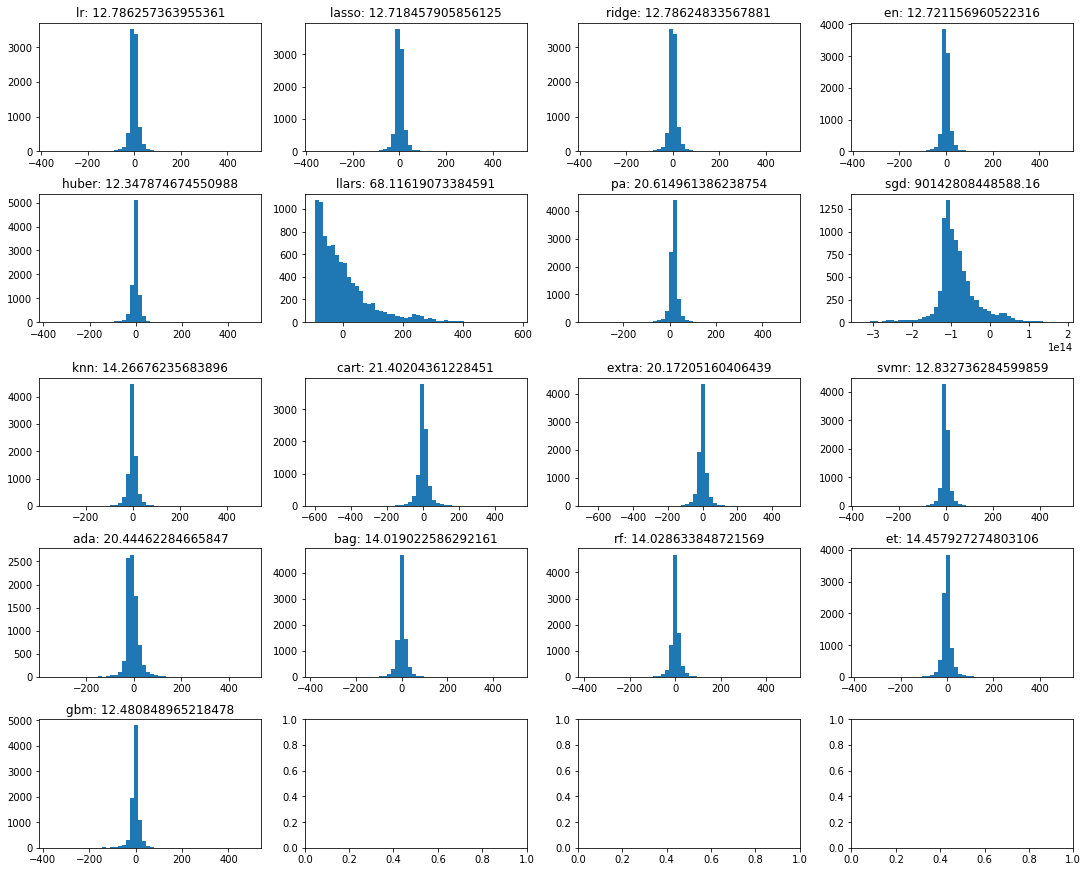

In [9]:
res = {**pdict_linear, **pdict_nonlinear, **pdict_ensemble}

n_bins = 50
fig, axs = pyplot.subplots(5, 4, sharey=False, constrained_layout=True, figsize=(15,12))
for index, key in enumerate(res):
    axs[int(index/4)][int(index%4)].title.set_text(key + ": " + str(res[key]["mae"]))
    axs[int(index/4)][int(index%4)].hist(test_y-res[key]["predictions"], bins=n_bins)

## Linear model forecast (huber, lowest MAE)

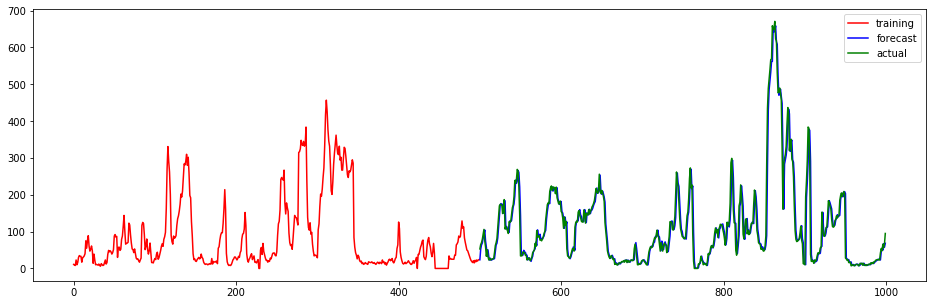

In [10]:
training_arr = list(train_y)[-500:]
training_len = len(training_arr)
training_ind = range(training_len)

forecast_arr = list(numpy.array(pdict_linear["huber"]["predictions"]).flatten())[:500]
forecast_len = len(forecast_arr)
forecast_ind = range(training_len, training_len + forecast_len)

actual_arr = list(test_y)[:500]
actual_len = len(actual_arr)
actual_ind = range(training_len, training_len + actual_len)

pyplot.figure(figsize=(16,5))
pyplot.plot(training_ind, training_arr, 'r')
pyplot.plot(forecast_ind, forecast_arr, 'b')
pyplot.plot(actual_ind, actual_arr, 'g')
pyplot.legend(["training", "forecast", "actual"])
pyplot.show()

## Non-Linear model forecast (svmr, lowest MAE)

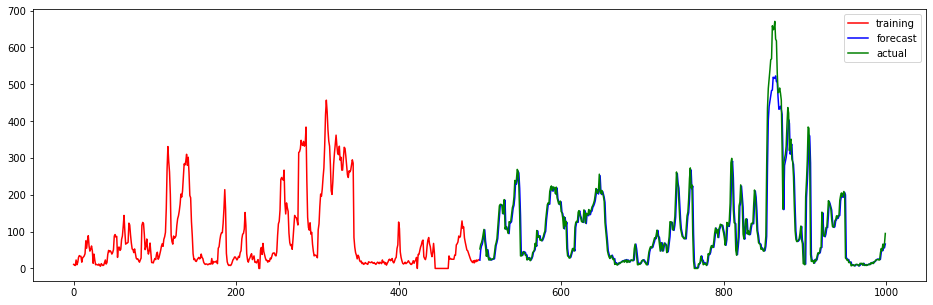

In [11]:
training_arr = list(train_y)[-500:]
training_len = len(training_arr)
training_ind = range(training_len)

forecast_arr = list(numpy.array(pdict_nonlinear["svmr"]["predictions"]).flatten())[:500]
forecast_len = len(forecast_arr)
forecast_ind = range(training_len, training_len + forecast_len)

actual_arr = list(test_y)[:500]
actual_len = len(actual_arr)
actual_ind = range(training_len, training_len + actual_len)

pyplot.figure(figsize=(16,5))
pyplot.plot(training_ind, training_arr, 'r')
pyplot.plot(forecast_ind, forecast_arr, 'b')
pyplot.plot(actual_ind, actual_arr, 'g')
pyplot.legend(["training", "forecast", "actual"])
pyplot.show()

## Ensemble model forecast (gbm, lowest MAE)

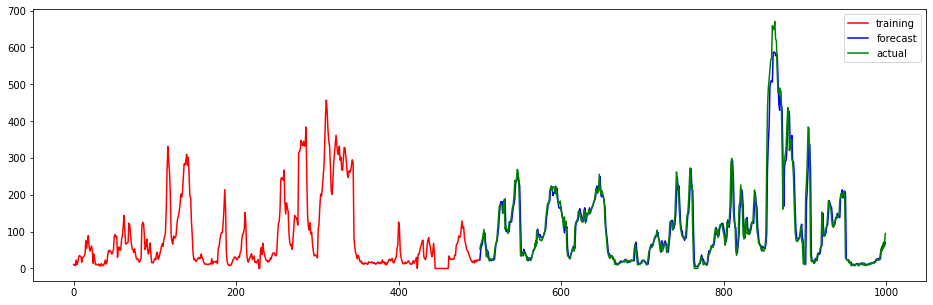

In [12]:
training_arr = list(train_y)[-500:]
training_len = len(training_arr)
training_ind = range(training_len)

forecast_arr = list(numpy.array(pdict_ensemble["gbm"]["predictions"]).flatten())[:500]
forecast_len = len(forecast_arr)
forecast_ind = range(training_len, training_len + forecast_len)

actual_arr = list(test_y)[:500]
actual_len = len(actual_arr)
actual_ind = range(training_len, training_len + actual_len)

pyplot.figure(figsize=(16,5))
pyplot.plot(training_ind, training_arr, 'r')
pyplot.plot(forecast_ind, forecast_arr, 'b')
pyplot.plot(actual_ind, actual_arr, 'g')
pyplot.legend(["training", "forecast", "actual"])
pyplot.show()

## Ensemble model forecast (ada, highest MAE)

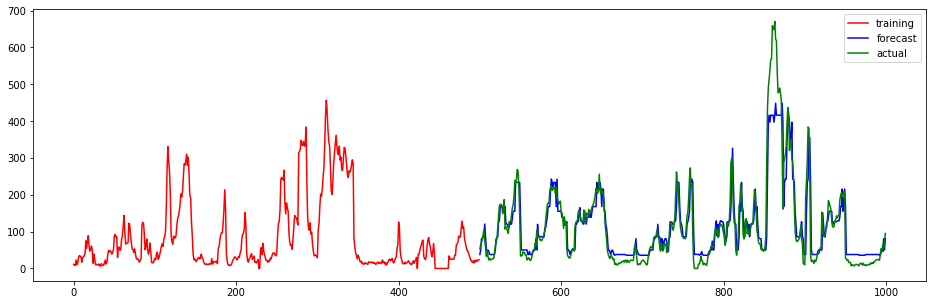

In [13]:
training_arr = list(train_y)[-500:]
training_len = len(training_arr)
training_ind = range(training_len)

forecast_arr = list(numpy.array(pdict_ensemble["ada"]["predictions"]).flatten())[:500]
forecast_len = len(forecast_arr)
forecast_ind = range(training_len, training_len + forecast_len)

actual_arr = list(test_y)[:500]
actual_len = len(actual_arr)
actual_ind = range(training_len, training_len + actual_len)

pyplot.figure(figsize=(16,5))
pyplot.plot(training_ind, training_arr, 'r')
pyplot.plot(forecast_ind, forecast_arr, 'b')
pyplot.plot(actual_ind, actual_arr, 'g')
pyplot.legend(["training", "forecast", "actual"])
pyplot.show()

## Stationarity
-19.094697 is lesser than -3.431. This suggests that we can reject the null hypothesis with a significance level of less than 1%. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(training_arr)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -4.276495
p-value: 0.000488
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570
